# Modelling notebook

This notebook contains some of the models that we run during our experimentations. It can be considered a draft file and has been included for illustrative purposes only.

In [1]:
# Custom functions and setup

from functions_auto import *
import config

# Other packages 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Tensorflow

import tensorflow as tf

#Yumna commented out: needed these lines of code to run some models on Saturn
#gpu_devices = tf.config.experimental.list_physical_devices('GPU')
#for device in gpu_devices:
#    tf.config.experimental.set_memory_growth(device, True)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.layers import Flatten, Dense, Embedding, LSTM, GRU, Reshape
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Concatenate, Lambda, concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import Sequence, plot_model

#Yumna added imports
from keras import backend as K
from tcn import TCN, tcn_full_summary #pip install keras-tcn
import tensorflow_hub as hub #pip install tensorflow_hub
import tensorflow_text as text #pip install tensorflow_text

# Set seed

tf.random.set_seed(1)


## Functions

In [2]:
def get_processed_dataset(datasetname):
    return pd.read_csv(config.processed_datasets[datasetname])

def preprocess_for_siamese(training_dataname, max_len, embedding_dim, batch_size):

    MAX_WORDS = 10000
    TRAINING_PROP = 0.8

    training_data = get_processed_dataset(training_dataname)
    tokenizer = get_tokenizer(training_data, max_words=MAX_WORDS)
    embed_matrix = get_embed_matrix(tokenizer, embedding_dim=embedding_dim)

    training_data_siamese = DataGeneratorSiamese(training_data.iloc[0:int(TRAINING_PROP*len(training_data))], max_len=max_len, tokenizer=tokenizer, batch_size=batch_size, shuffle=True)
    validation_data_siamese = DataGeneratorSiamese(training_data.iloc[int(TRAINING_PROP*len(training_data)):], max_len=max_len, tokenizer=tokenizer,batch_size=batch_size, shuffle=True)
    training_data_siamese.on_epoch_end() # this is a hack for "'DataGenerator' object has no attribute 'index'". 
    validation_data_siamese.on_epoch_end() # this is a hack for "'DataGenerator' object has no attribute 'index'". 

    return tokenizer, embed_matrix, training_data_siamese, validation_data_siamese

def run_model(chosen_datasetname, custom_modelname, model_fun, optimizer, BATCH_SIZE = 64, EPOCHS = 50, STEPS_PER_EPOCH = None, SHUFFLE = True):

    # Settings

    MAX_LEN = 30
    EMBEDDING_DIM = 50

    # Get tokenizer, embedding matrix, and data

    tokenizer, embed_matrix, training_data, validation_data = preprocess_for_siamese(chosen_datasetname, MAX_LEN, EMBEDDING_DIM, BATCH_SIZE)
    # tokenizer, embed_matrix, training_data, validation_data = preprocess_for_siamese(chosen_datasetname, 'valid_2022_task2', MAX_LEN, EMBEDDING_DIM, BATCH_SIZE)

    model = model_fun(max_len=MAX_LEN,
                        tokenizer=tokenizer, 
                        embed_matrix=embed_matrix,
                        embedding_dim=EMBEDDING_DIM,
                        optimizer=optimizer)

    # Checkpoints

    checkpoint_path = config.checkpoints.get("dir")+custom_modelname+config.checkpoints.get("name")

    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        verbose=1, 
        save_weights_only=True,
        save_freq=5*1000, # Approx every 5 epoch
        #save_freq=5*BATCH_SIZE
        )

    model.save_weights(checkpoint_path.format(epoch=0))

    #stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

    # Fit
    if STEPS_PER_EPOCH is not None:
        history = model.fit(training_data,
                            validation_data=validation_data,
                            verbose=1,
                            batch_size=BATCH_SIZE,
                            epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            shuffle=SHUFFLE,
                            callbacks=[cp_callback])
    else:
        history = model.fit(training_data,
                    validation_data=validation_data,
                    verbose=1,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    #steps_per_epoch=STEPS_PER_EPOCH,
                    #shuffle=SHUFFLE,
                    callbacks=[cp_callback])
                    #callbacks=[cp_callback,stop_callback])

    # Plots

    acc = pd.DataFrame({"training acc":history.history['acc'],
                            "validation acc": history.history['val_acc']})
    acc_plot = acc.plot()
    fig1 = acc_plot.get_figure()
    fig1.savefig(config.base_dir+'plots/'+custom_modelname+'_acc.png')

    loss = pd.DataFrame({"training loss":history.history['loss'],
                            "validation loss": history.history['val_loss']})
    loss_plot = loss.plot()
    fig2 = loss_plot.get_figure()
    fig2.savefig(config.base_dir+'plots/'+custom_modelname+'_loss.png')

    # History

    history_path = config.history['dir']+custom_modelname+'.csv'
    pd.DataFrame.from_dict(history.history).to_csv(history_path,index=False)

### Define optimizers and architectures

In [3]:
# Optimizers

opt_nath = Adam(clipnorm=1.5) # Nath (2021)
opt_sgd1 = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9, decay=0.01) # Asmus tries to see if it fixes 2022-problem

In [36]:
# Model architectures

def model_nath(max_len, tokenizer, embed_matrix, embedding_dim, optimizer):

    input_1 = Input(shape=(max_len,))
    input_2 = Input(shape=(max_len,))

    lstm_layer = Bidirectional(LSTM(50, dropout=0.2, recurrent_dropout=0.2)) # Won't work on GPU
    embeddings_initializer = Constant(embed_matrix)
    emb =  Embedding(len(tokenizer.word_index)+1,
                     embedding_dim,
                     embeddings_initializer=embeddings_initializer,
                     input_length=max_len,
                     weights=[embed_matrix],
                     trainable=True)

    e1 = emb(input_1)
    x1 = lstm_layer(e1)

    e2 = emb(input_2)
    x2 = lstm_layer(e2)

    mhd = lambda x: exponent_neg_cosine_distance(x[0], x[1]) 
    merged = Lambda(function=mhd, output_shape=lambda x: x[0], name='cosine_distance')([x1, x2])
    preds = Dense(1, activation='sigmoid')(merged)
    model = Model(inputs=[input_1, input_2], outputs=preds)

    model.compile(loss = "binary_crossentropy",  metrics=['acc'], optimizer = optimizer)

    return model



In [6]:
# Add CNN

def model_CNN(max_len, tokenizer, embed_matrix, embedding_dim, optimizer):

    input_1 = Input(shape=(max_len,))
    input_2 = Input(shape=(max_len,))

    lstm_layer = Bidirectional(LSTM(50, dropout=0.2)) # recurrent_dropout=0.2, else no GPU
    
    embeddings_initializer = Constant(embed_matrix)
    emb =  Embedding(len(tokenizer.word_index)+1,
                     embedding_dim,
                     embeddings_initializer=embeddings_initializer,
                     input_length=max_len,
                     weights=[embed_matrix],
                     trainable=True)

    e1 = emb(input_1)
    e11 = tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(e1)
    e111 = tf.keras.layers.MaxPooling1D(pool_size=2)(e11)
    e1111 = tf.keras.layers.Dropout(0.2)(e111)
    x1 = lstm_layer(e1111)

    e2 = emb(input_2)
    e22 = tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(e2)
    e222 = tf.keras.layers.MaxPooling1D(pool_size=2)(e22)
    e2222 = tf.keras.layers.Dropout(0.2)(e222)
    x2 = lstm_layer(e2222)

    mhd = lambda x: exponent_neg_cosine_distance(x[0], x[1]) 
    merged = Lambda(function=mhd, output_shape=lambda x: x[0], name='cosine_distance')([x1, x2])
    preds = Dense(1, activation='sigmoid')(merged)
    model = Model(inputs=[input_1, input_2], outputs=preds)

    model.compile(loss = "binary_crossentropy",  metrics=['acc'], optimizer = optimizer)

    return model


def model_pure_CNN(max_len, tokenizer, embed_matrix, embedding_dim, optimizer):

    input_1 = Input(shape=(max_len,))
    input_2 = Input(shape=(max_len,))

    #lstm_layer = Bidirectional(LSTM(50, dropout=0.2)) # recurrent_dropout=0.2, else no GPU
    
    embeddings_initializer = Constant(embed_matrix)
    emb =  Embedding(len(tokenizer.word_index)+1,
                     embedding_dim,
                     embeddings_initializer=embeddings_initializer,
                     input_length=max_len,
                     weights=[embed_matrix],
                     trainable=True)

    e1 = emb(input_1)
    e11 = tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(e1)
    e111 = tf.keras.layers.MaxPooling1D(pool_size=2)(e11)
    x1 = tf.keras.layers.Dropout(0.2)(e111)
    x1 = tf.keras.layers.Flatten(x1)

    e2 = emb(input_2)
    e22 = tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(e2)
    e222 = tf.keras.layers.MaxPooling1D(pool_size=2)(e22)
    x2 = tf.keras.layers.Dropout(0.2)(e222)
    x2 = tf.keras.layers.Flatten(x2)

    mhd = lambda x: exponent_neg_cosine_distance(x[0], x[1]) 
    merged = Lambda(function=mhd, output_shape=lambda x: x[0], name='cosine_distance')([x1, x2])
    preds = Dense(1, activation='sigmoid')(merged)
    model = Model(inputs=[input_1, input_2], outputs=preds)

    model.compile(loss = "binary_crossentropy",  metrics=['acc'], optimizer = optimizer)

    return model


    #Add CNN with normalization



def model_CNN_normal(max_len, tokenizer, embed_matrix, embedding_dim, optimizer):

    input_1 = Input(shape=(max_len,))
    input_2 = Input(shape=(max_len,))

    lstm_layer = Bidirectional(LSTM(50, dropout=0.2)) # recurrent_dropout=0.2, else no GPU
    
    embeddings_initializer = Constant(embed_matrix)
    emb =  Embedding(len(tokenizer.word_index)+1,
                     embedding_dim,
                     embeddings_initializer=embeddings_initializer,
                     input_length=max_len,
                     weights=[embed_matrix],
                     trainable=True)

    e1 = emb(input_1)
    e11 = tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same')(e1)
    e111 = tf.keras.layers.BatchNormalization()(e11)
    e1111 = tf.keras.layers.Activation('relu')(e111)
    e11111 = tf.keras.layers.MaxPooling1D(pool_size=2)(e1111)
    x1 = lstm_layer(e11111)

    e2 = emb(input_2)
    e22 = tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(e2)
    e222 = tf.keras.layers.BatchNormalization()(e22)
    e2222 = tf.keras.layers.Activation('relu')(e222)
    e22222 = tf.keras.layers.MaxPooling1D(pool_size=2)(e2222)
    x2 = lstm_layer(e22222)

    mhd = lambda x: exponent_neg_cosine_distance(x[0], x[1]) 
    merged = Lambda(function=mhd, output_shape=lambda x: x[0], name='cosine_distance')([x1, x2])
    preds = Dense(1, activation='sigmoid')(merged)
    model = Model(inputs=[input_1, input_2], outputs=preds)

    model.compile(loss = "binary_crossentropy",  metrics=['acc'], optimizer = optimizer)

    return model


def model_CNN_normal_dropout(max_len, tokenizer, embed_matrix, embedding_dim, optimizer):

    input_1 = Input(shape=(max_len,))
    input_2 = Input(shape=(max_len,))

    lstm_layer = Bidirectional(LSTM(50, dropout=0.2)) # recurrent_dropout=0.2, else no GPU
    
    embeddings_initializer = Constant(embed_matrix)
    emb =  Embedding(len(tokenizer.word_index)+1,
                     embedding_dim,
                     embeddings_initializer=embeddings_initializer,
                     input_length=max_len,
                     weights=[embed_matrix],
                     trainable=True)

    e1 = emb(input_1)
    e11 = tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(e1)
    e111 = tf.keras.layers.BatchNormalization()(e11)
    e1111 = tf.keras.layers.MaxPooling1D(pool_size=2)(e111)
    e11111 = tf.keras.layers.Dropout(0.2)(e1111)
    x1 = lstm_layer(e11111)

    e2 = emb(input_2)
    e22 = tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(e2)
    e222 = tf.keras.layers.BatchNormalization()(e22)
    e2222 = tf.keras.layers.MaxPooling1D(pool_size=2)(e222)
    e22222 = tf.keras.layers.Dropout(0.2)(e2222)
    x2 = lstm_layer(e22222)

    mhd = lambda x: exponent_neg_cosine_distance(x[0], x[1]) 
    merged = Lambda(function=mhd, output_shape=lambda x: x[0], name='cosine_distance')([x1, x2])
    preds = Dense(1, activation='sigmoid')(merged)
    model = Model(inputs=[input_1, input_2], outputs=preds)

    model.compile(loss = "binary_crossentropy",  metrics=['acc'], optimizer = optimizer)

    return model

In [6]:
# TCN model

def model_tcn(max_len, tokenizer, embed_matrix, embedding_dim, optimizer):
    time_steps = 20
    input_dim = 300
    
    input_1 = Input(shape=(max_len,))
    input_2 = Input(shape=(max_len,))
    
    tcn_layer = TCN(input_shape=(time_steps, input_dim))
    embeddings_initializer = Constant(embed_matrix)
    emb =  Embedding(len(tokenizer.word_index)+1,
                     embedding_dim,
                     embeddings_initializer=embeddings_initializer,
                     input_length=max_len,
                     weights=[embed_matrix],
                     trainable=True)

    e1 = emb(input_1)
    x1 = tcn_layer(e1)

    e2 = emb(input_2)
    x2 = tcn_layer(e2)

    mhd = lambda x: exponent_neg_cosine_distance(x[0], x[1]) 
    merged = Lambda(function=mhd, output_shape=lambda x: x[0], name='cosine_distance')([x1, x2])
    preds = Dense(1, activation='sigmoid')(merged)
    model = Model(inputs=[input_1, input_2], outputs=preds)

    model.compile(loss = "binary_crossentropy",  metrics=['acc'], optimizer = optimizer)

    return model

In [11]:
# Bert embedding

def preprocess_for_siamese_bert(training_dataname):
    
    TRAINING_PROP = 0.8
    max_len = 300
    batch_size = 64
    
    training_data = get_processed_dataset(training_dataname)
    
    training_data_siamese = DataGeneratorSiamese2(training_data.iloc[0:int(TRAINING_PROP*len(training_data))], max_len=max_len, batch_size=batch_size, shuffle=True)
    validation_data_siamese = DataGeneratorSiamese2(training_data.iloc[int(TRAINING_PROP*len(training_data)):],max_len=max_len, batch_size=batch_size, shuffle=True)
    training_data_siamese.on_epoch_end() # this is a hack for "'DataGenerator' object has no attribute 'index'". 
    validation_data_siamese.on_epoch_end() # this is a hack for "'DataGenerator' object has no attribute 'index'". 

    return training_data_siamese, validation_data_siamese

def run_model_bert(chosen_datasetname, custom_modelname, model_fun, optimizer, BATCH_SIZE = 64, EPOCHS = 50, SHUFFLE = True):

    training_data, validation_data = preprocess_for_siamese_bert(chosen_datasetname)

    model = model_fun(optimizer=optimizer)

    # Checkpoints

    checkpoint_path = config.checkpoints.get("dir")+custom_modelname+config.checkpoints.get("name")

    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        verbose=1, 
        save_weights_only=True,
        save_freq=5*1000, # Approx every 5 epoch
        #save_freq=5*BATCH_SIZE
        )

    model.save_weights(checkpoint_path.format(epoch=0))


    history = model.fit(training_data,
                validation_data=validation_data,
                verbose=1,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                #steps_per_epoch=STEPS_PER_EPOCH,
                #shuffle=SHUFFLE,
                callbacks=[cp_callback])
                #callbacks=[cp_callback,stop_callback])

    # Plots

    acc = pd.DataFrame({"training acc":history.history['acc'],
                            "validation acc": history.history['val_acc']})
    acc_plot = acc.plot()
    fig1 = acc_plot.get_figure()
    fig1.savefig(config.base_dir+'plots/'+custom_modelname+'_acc.png')

    loss = pd.DataFrame({"training loss":history.history['loss'],
                            "validation loss": history.history['val_loss']})
    loss_plot = loss.plot()
    fig2 = loss_plot.get_figure()
    fig2.savefig(config.base_dir+'plots/'+custom_modelname+'_loss.png')

    # History

    history_path = config.history['dir']+custom_modelname+'.csv'
    pd.DataFrame.from_dict(history.history).to_csv(history_path,index=False)


def bert(optimizer):
    bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
    bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

    text_input = Input(shape=(), dtype=tf.string, name='text')
    preprocessed_text = bert_preprocess(text_input)
    outputs = bert_encoder(preprocessed_text)

    input_1 = Input(shape=(), dtype=tf.string, name='text_1')
    preprocessed_text_1 = bert_preprocess(input_1)
    outputs_1 = bert_encoder(preprocessed_text_1)
    e1 = Reshape((768, 1))(outputs_1['pooled_output'])

    input_2 = Input(shape=(), dtype=tf.string, name='text_2')
    preprocessed_text_2 = bert_preprocess(input_2)
    outputs_2 = bert_encoder(preprocessed_text_2)
    e2 = Reshape((768, 1))(outputs_2['pooled_output'])

    lstm_layer = Bidirectional(LSTM(50, dropout=0.2)) 

    x1 = lstm_layer(e1)
    x2 = lstm_layer(e2)

    mhd = lambda x: exponent_neg_cosine_distance(x[0], x[1]) 
    merged = Lambda(function=mhd, output_shape=lambda x: x[0], name='cosine_distance')([x1, x2])
    preds = Dense(1, activation='sigmoid')(merged)
    model = Model(inputs=[input_1, input_2], outputs=preds)

    model.compile(loss = "binary_crossentropy",  metrics=['acc'], optimizer = optimizer)
    
    return model

In [15]:
def gru(max_len, tokenizer, embed_matrix, embedding_dim, optimizer):
    input_1 = Input(shape=(max_len,))
    input_2 = Input(shape=(max_len,))

    gru_layer = GRU(50, dropout=0.2) 
    embeddings_initializer = Constant(embed_matrix)
    emb =  Embedding(len(tokenizer.word_index)+1,
                     embedding_dim,
                     embeddings_initializer=embeddings_initializer,
                     input_length=max_len,
                     weights=[embed_matrix],
                     trainable=True)

    e1 = emb(input_1)
    x1 = gru_layer(e1)

    e2 = emb(input_2)
    x2 = gru_layer(e2)

    mhd = lambda x: exponent_neg_cosine_distance(x[0], x[1]) 
    merged = Lambda(function=mhd, output_shape=lambda x: x[0], name='cosine_distance')([x1, x2])
    preds = Dense(1, activation='sigmoid')(merged)
    model = Model(inputs=[input_1, input_2], outputs=preds)

    model.compile(loss = "binary_crossentropy",  metrics=['acc'], optimizer = optimizer)

    return model

In [12]:
def two_bilstm(max_len, tokenizer, embed_matrix, embedding_dim, optimizer):
    input_1 = Input(shape=(max_len,))
    input_2 = Input(shape=(max_len,))

    lstm_layer = Bidirectional(LSTM(50, dropout=0.2, return_sequences = True)) # Won't work on GPU
    lstm_layer2 = Bidirectional(LSTM(50, dropout=0.2)) 

    embeddings_initializer = Constant(embed_matrix)
    emb =  Embedding(len(tokenizer.word_index)+1,
                     embedding_dim,
                     embeddings_initializer=embeddings_initializer,
                     input_length=max_len,
                     weights=[embed_matrix],
                     trainable=True)

    e1 = emb(input_1)
    x1 = lstm_layer(e1)
    x11 = lstm_layer2(x1)

    e2 = emb(input_2)
    x2 = lstm_layer(e2)
    x22 = lstm_layer2(x2)

    mhd = lambda x: exponent_neg_cosine_distance(x[0], x[1]) 
    merged = Lambda(function=mhd, output_shape=lambda x: x[0], name='cosine_distance')([x1, x2])
    preds = Dense(1, activation='sigmoid')(merged)
    model = Model(inputs=[input_1, input_2], outputs=preds)

    model.compile(loss = "binary_crossentropy",  metrics=['acc'], optimizer = optimizer)

    return model

### Run models

### 2022: Five different models on task2

Found 400000 word vectors.
Loaded 400000 word vectors.
(55904, 50)


2022-04-18 11:35:20.143208: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-18 11:35:20.143457: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-18 11:35:20.143676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 11:35:20.144269: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
20

Epoch 1/100


2022-04-18 11:35:31.230696: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


825/825 [==============================] - 293s 345ms/step - loss: 0.7351 - acc: 0.5396 - val_loss: 0.6920 - val_acc: 0.5325
Epoch 2/100
825/825 [==============================] - 283s 343ms/step - loss: 0.6857 - acc: 0.5437 - val_loss: 0.6922 - val_acc: 0.5401
Epoch 3/100
825/825 [==============================] - 284s 344ms/step - loss: 0.6779 - acc: 0.5759 - val_loss: 0.6882 - val_acc: 0.5451
Epoch 4/100
825/825 [==============================] - 283s 344ms/step - loss: 0.6683 - acc: 0.6055 - val_loss: 0.6903 - val_acc: 0.5470
Epoch 5/100
825/825 [==============================] - 284s 345ms/step - loss: 0.6549 - acc: 0.6295 - val_loss: 0.6971 - val_acc: 0.5445
Epoch 6/100
825/825 [==============================] - 285s 345ms/step - loss: 0.6377 - acc: 0.6576 - val_loss: 0.6988 - val_acc: 0.5404
Epoch 7/100
 50/825 [>.............................] - ETA: 4:18 - loss: 0.6275 - acc: 0.6728
Epoch 00007: saving model to /home/jovyan/examples/examples/tensorflow/project-2022-group-4/chec

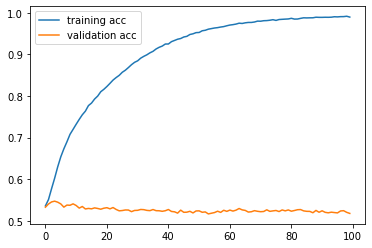

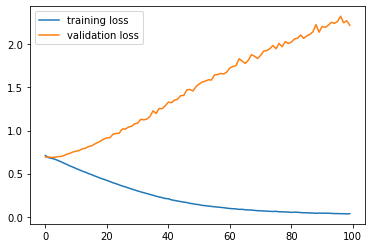

In [8]:
#Replicating 2021 results

run_model(chosen_datasetname='train_2021',
          custom_modelname='nath2021_on_2021_task1', # test* is in gitignore, for testing without uploading
          model_fun=model_nath,
          optimizer=opt_nath,
          BATCH_SIZE=64,
          EPOCHS=100)

Found 400000 word vectors.
Loaded 400000 word vectors.
(55904, 50)
Epoch 1/25


2022-04-17 22:45:50.244585: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-04-17 22:45:50.322654: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


825/825 [==============================] - 54s 32ms/step - loss: 0.7761 - acc: 0.5349 - val_loss: 0.6943 - val_acc: 0.5144
Epoch 2/25
825/825 [==============================] - 26s 31ms/step - loss: 0.6874 - acc: 0.5423 - val_loss: 0.6921 - val_acc: 0.5366
Epoch 3/25
825/825 [==============================] - 25s 31ms/step - loss: 0.6747 - acc: 0.5809 - val_loss: 0.6944 - val_acc: 0.5331
Epoch 4/25
825/825 [==============================] - 26s 31ms/step - loss: 0.6576 - acc: 0.6195 - val_loss: 0.6962 - val_acc: 0.5121
Epoch 5/25
825/825 [==============================] - 25s 30ms/step - loss: 0.6342 - acc: 0.6676 - val_loss: 0.7045 - val_acc: 0.5200
Epoch 6/25
825/825 [==============================] - 25s 31ms/step - loss: 0.6030 - acc: 0.7137 - val_loss: 0.7151 - val_acc: 0.5179
Epoch 7/25
 49/825 [>.............................] - ETA: 22s - loss: 0.5741 - acc: 0.7467
Epoch 00007: saving model to /home/jovyan/examples/examples/tensorflow/project-2022-group-4/checkpoints/model_tcn_o

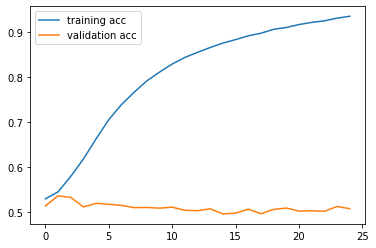

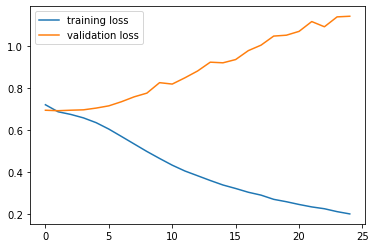

In [22]:
#curve is basically identical to the two CNN models
run_model(chosen_datasetname='train_2021',
          custom_modelname='model_tcn_on_2021',
          model_fun=model_tcn,
          optimizer=opt_nath,
          BATCH_SIZE=64,
          EPOCHS=25)

Found 400000 word vectors.
Loaded 400000 word vectors.
(55904, 50)
Epoch 1/25
825/825 [==============================] - 30s 30ms/step - loss: 0.6943 - acc: 0.5387 - val_loss: 0.6867 - val_acc: 0.5470
Epoch 2/25
825/825 [==============================] - 24s 29ms/step - loss: 0.6771 - acc: 0.5747 - val_loss: 0.6875 - val_acc: 0.5583
Epoch 3/25
825/825 [==============================] - 24s 29ms/step - loss: 0.6593 - acc: 0.6165 - val_loss: 0.6883 - val_acc: 0.5561
Epoch 4/25
825/825 [==============================] - 23s 28ms/step - loss: 0.6343 - acc: 0.6527 - val_loss: 0.6954 - val_acc: 0.5438
Epoch 5/25
825/825 [==============================] - 23s 28ms/step - loss: 0.6053 - acc: 0.6898 - val_loss: 0.7394 - val_acc: 0.5552
Epoch 6/25
825/825 [==============================] - 23s 28ms/step - loss: 0.5719 - acc: 0.7227 - val_loss: 0.7413 - val_acc: 0.5549
Epoch 7/25
 50/825 [>.............................] - ETA: 20s - loss: 0.5464 - acc: 0.7385
Epoch 00007: saving model to /home/jo

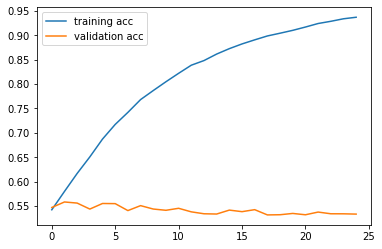

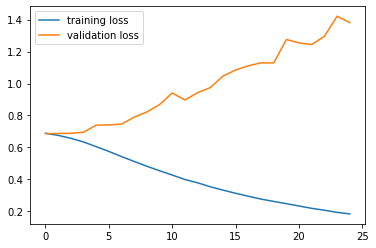

In [24]:
run_model(chosen_datasetname='train_2022_task2',
          custom_modelname='model_cnn_norm_on_2022',
          model_fun=model_CNN_normal,
          optimizer=opt_nath,
          BATCH_SIZE=64,
          EPOCHS=25)

Found 400000 word vectors.
Loaded 400000 word vectors.
(55904, 50)
Epoch 1/25
825/825 [==============================] - 30s 30ms/step - loss: 0.6992 - acc: 0.5359 - val_loss: 0.6844 - val_acc: 0.5599
Epoch 2/25
825/825 [==============================] - 23s 28ms/step - loss: 0.6762 - acc: 0.5806 - val_loss: 0.6799 - val_acc: 0.5661
Epoch 3/25
825/825 [==============================] - 24s 29ms/step - loss: 0.6590 - acc: 0.6092 - val_loss: 0.6843 - val_acc: 0.5671
Epoch 4/25
825/825 [==============================] - 24s 29ms/step - loss: 0.6403 - acc: 0.6407 - val_loss: 0.6855 - val_acc: 0.5666
Epoch 5/25
825/825 [==============================] - 24s 29ms/step - loss: 0.6160 - acc: 0.6722 - val_loss: 0.6936 - val_acc: 0.5535
Epoch 6/25
825/825 [==============================] - 24s 29ms/step - loss: 0.5901 - acc: 0.6994 - val_loss: 0.7045 - val_acc: 0.5605
Epoch 7/25
 50/825 [>.............................] - ETA: 21s - loss: 0.5557 - acc: 0.7309
Epoch 00007: saving model to /home/jo

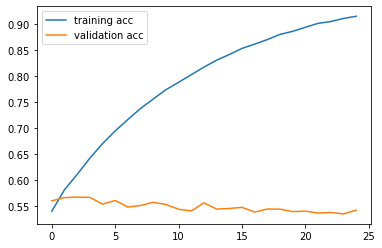

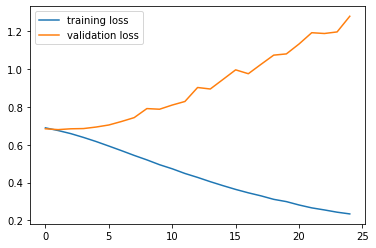

In [25]:
run_model(chosen_datasetname='train_2022_task2',
          custom_modelname='model_cnn_norm_dropout_on_2022',
          model_fun=model_CNN_normal_dropout,
          optimizer=opt_nath,
          BATCH_SIZE=64,
          EPOCHS=25)

Found 400000 word vectors.
Loaded 400000 word vectors.
(45360, 50)
Epoch 1/25
571/571 [==============================] - 26s 40ms/step - loss: 0.6740 - acc: 0.5925 - val_loss: 0.6684 - val_acc: 0.6106
Epoch 2/25
571/571 [==============================] - 23s 41ms/step - loss: 0.6637 - acc: 0.6160 - val_loss: 0.6665 - val_acc: 0.6099
Epoch 3/25
571/571 [==============================] - 23s 40ms/step - loss: 0.6582 - acc: 0.6159 - val_loss: 0.6679 - val_acc: 0.6101
Epoch 4/25
571/571 [==============================] - 23s 40ms/step - loss: 0.6500 - acc: 0.6160 - val_loss: 0.6710 - val_acc: 0.6100
Epoch 5/25
571/571 [==============================] - 23s 40ms/step - loss: 0.6387 - acc: 0.6163 - val_loss: 0.6698 - val_acc: 0.6095
Epoch 6/25
571/571 [==============================] - 23s 40ms/step - loss: 0.6262 - acc: 0.6422 - val_loss: 0.6733 - val_acc: 0.6007
Epoch 7/25
571/571 [==============================] - 23s 40ms/step - loss: 0.6126 - acc: 0.6738 - val_loss: 0.6767 - val_acc: 0.

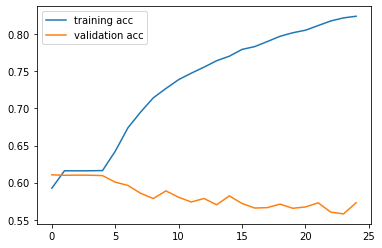

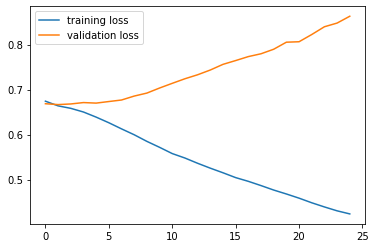

In [16]:
run_model(chosen_datasetname='train_2022_task2',
          custom_modelname='gru_on_2022',
          model_fun=gru,
          optimizer=opt_nath,
          BATCH_SIZE=64,
          EPOCHS=25)

In [ ]:
# Takes a long time to run
run_model_bert(chosen_datasetname='train_2022_task2',
          custom_modelname='bert_on_2022',
          model_fun=bert,
          optimizer=opt_nath,
          BATCH_SIZE=64,
          EPOCHS=25)

In [ ]:
run_model(chosen_datasetname='train_2022_task2',
          custom_modelname='two_bilstm_on_2022',
          model_fun=two_bilstm,
          optimizer=opt_nath,
          BATCH_SIZE=64,
          EPOCHS=25)